In [1]:
#Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import shap
from sklearn.model_selection import GridSearchCV

In [2]:
import pickle5 as pickle
import os

In [3]:
#Creating Fucntion for adding new features seq hour, day, month, weekday, year, weekend, day/night
def Create_Features(data):
  data['seg_hour']=data['DatetimeEnd'].dt.hour
  data['day']=data['DatetimeEnd'].dt.day
  data['month']=data['DatetimeEnd'].dt.month
  data['weekday']=data['DatetimeEnd'].dt.weekday
  data['year']=data['DatetimeEnd'].dt.year
  data['weekend']=[1 if data['weekday'][i] in [5,6] else 0 for i in range(len(data))]
  data['day/night']=[1 if data['seg_hour'][i]<18 and data['seg_hour'][i]>6 else 0 for i in range(len(data))] # day equals 1 and night equals 0
  return data

In [4]:
#Removing outliers Function

def detect_outliers(data):
    outliers=[]
    threshold=3
    mean = np.mean(data)
    std =np.std(data)
    
    
    for i in data:
        z_score= (i - mean)/std 
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

In [5]:
# Datasets input

data1=pd.read_csv("/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/data/GR_1_22830_2023_timeseries.csv")
data5=pd.read_csv("/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/data/GR_5_64780_2023_timeseries.csv")
data7=pd.read_csv("/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/data/GR_7_22824_2023_timeseries.csv")
data8=pd.read_csv("/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/data/GR_8_22883_2023_timeseries.csv")
data10=pd.read_csv("/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/data/GR_10_22962_2023_timeseries.csv")
data6001=pd.read_csv("/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/data/GR_6001_64781_2023_timeseries.csv")

In [6]:
#Merging all datasets

data=pd.concat([data1,data5,data7,data8,data10,data6001])
data.shape

(18762, 17)

In [7]:
data['AirPollutant'].unique()

array(['SO2', 'PM10', 'O3', 'NO2', 'CO', 'PM2.5'], dtype=object)

In [8]:
data.columns

Index(['Countrycode', 'Namespace', 'AirQualityNetwork', 'AirQualityStation',
       'AirQualityStationEoICode', 'SamplingPoint', 'SamplingProcess',
       'Sample', 'AirPollutant', 'AirPollutantCode', 'AveragingTime',
       'Concentration', 'UnitOfMeasurement', 'DatetimeBegin', 'DatetimeEnd',
       'Validity', 'Verification'],
      dtype='object')

In [9]:
#Dropping unnecessary columns and setting datetime column as index
data=data.drop(['SamplingPoint','SamplingProcess','Sample','AveragingTime','UnitOfMeasurement','DatetimeBegin','Verification','Namespace','Countrycode','AirQualityNetwork', 'AirQualityStation',
       'AirQualityStationEoICode','AirPollutantCode','Validity'],axis=1)
data['DatetimeEnd']=pd.to_datetime(data['DatetimeEnd'],utc=True)

In [10]:
data.head()

,AirPollutant,Concentration,DatetimeEnd
0,SO2,10.0,2023-01-01 00:00:00+00:00
1,SO2,10.0,2023-01-01 01:00:00+00:00
2,SO2,10.0,2023-01-01 02:00:00+00:00
3,SO2,9.0,2023-01-01 03:00:00+00:00
4,SO2,10.0,2023-01-01 04:00:00+00:00


In [11]:
#Creting different dataframes for its Pollutant to run the model
# data=data[data["AirPollutant"]=="CO"]
# data_NO2=data[data["AirPollutant"]=="NO2"]
# data=data[data["AirPollutant"]=="O3"]
# data=data[data["AirPollutant"]=="PM10"]
data=data[data["AirPollutant"]=="PM2.5"]
# data=data[data["AirPollutant"]=="SO2"]
data.head()

,AirPollutant,Concentration,DatetimeEnd
0,PM2.5,83.0,2023-01-01 00:00:00+00:00
1,PM2.5,71.0,2023-01-01 01:00:00+00:00
2,PM2.5,77.0,2023-01-01 02:00:00+00:00
3,PM2.5,63.0,2023-01-01 03:00:00+00:00
4,PM2.5,54.0,2023-01-01 04:00:00+00:00


In [12]:
#Checking null values
data.dropna(axis=0,inplace=True)
data.isnull().sum()

AirPollutant     0
Concentration    0
DatetimeEnd      0
dtype: int64

In [13]:
data.reset_index(inplace=True)
data.tail()

,index,AirPollutant,Concentration,DatetimeEnd
3041,3087,PM2.5,13.0,2023-05-09 17:00:00+00:00
3042,3088,PM2.5,21.0,2023-05-09 18:00:00+00:00
3043,3089,PM2.5,18.0,2023-05-09 19:00:00+00:00
3044,3090,PM2.5,24.0,2023-05-09 20:00:00+00:00
3045,3091,PM2.5,17.0,2023-05-09 21:00:00+00:00


In [14]:
Create_Features(data)

,index,AirPollutant,Concentration,DatetimeEnd,seg_hour,day,month,weekday,year,weekend,day/night
0,0,PM2.5,83.0,2023-01-01 00:00:00+00:00,0,1,1,6,2023,1,0
1,1,PM2.5,71.0,2023-01-01 01:00:00+00:00,1,1,1,6,2023,1,0
2,2,PM2.5,77.0,2023-01-01 02:00:00+00:00,2,1,1,6,2023,1,0
3,3,PM2.5,63.0,2023-01-01 03:00:00+00:00,3,1,1,6,2023,1,0
4,4,PM2.5,54.0,2023-01-01 04:00:00+00:00,4,1,1,6,2023,1,0
...,...,...,...,...,...,...,...,...,...,...,...
3041,3087,PM2.5,13.0,2023-05-09 17:00:00+00:00,17,9,5,1,2023,0,1
3042,3088,PM2.5,21.0,2023-05-09 18:00:00+00:00,18,9,5,1,2023,0,0
3043,3089,PM2.5,18.0,2023-05-09 19:00:00+00:00,19,9,5,1,2023,0,0
3044,3090,PM2.5,24.0,2023-05-09 20:00:00+00:00,20,9,5,1,2023,0,0


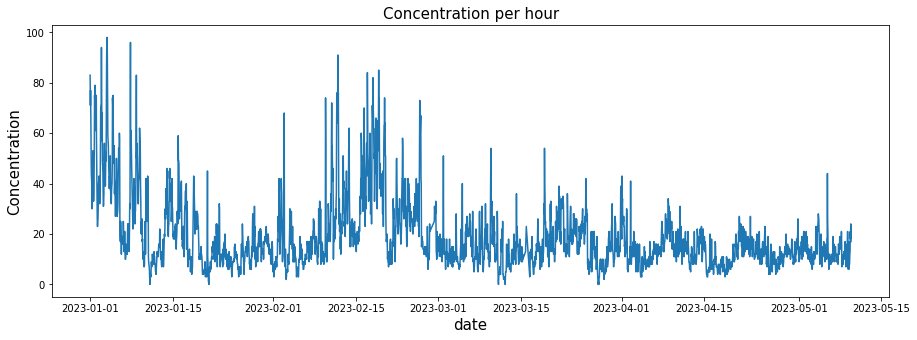

In [15]:
#plotting data concentration per hour lineplot
fig=plt.figure(figsize=(15,5))
sns.lineplot(data=data,x='DatetimeEnd',y='Concentration')
plt.title('Concentration per hour',fontsize=15)
plt.xlabel('date',fontsize=15)
plt.ylabel('Concentration',fontsize=15)
plt.show()

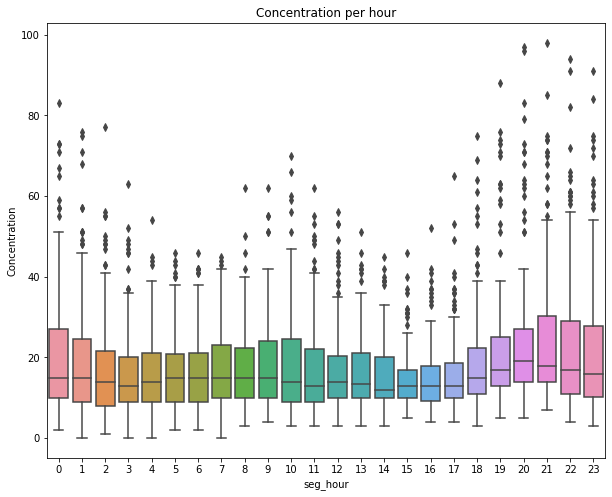

In [16]:
#Concentration per hour boxplot
fig, ax= plt.subplots(figsize= (10,8))
sns.boxplot(data=data,x='seg_hour',y='Concentration')
ax.set_title("Concentration per hour")
plt.show()

In [17]:
# Calculate the relevant statistics
median = data['Concentration'].median()
q1 = data['Concentration'].quantile(0.25)
q3 = data['Concentration'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

print("median",median)
print("q1",q1)
print("q3",q3)
print("iqr",iqr)
print("lower bound",lower_bound)
print("upper bound", upper_bound)


median 15.0
q1 10.0
q3 22.75
iqr 12.75
lower bound -9.125
upper bound 41.875


In [18]:
#Printing Outliers
outlier_pt=detect_outliers(data["Concentration"])
len(outlier_pt)

72

In [19]:
quantile1, quantile3= np.percentile(data['Concentration'],[25,75])
print(quantile1,quantile3)

10.0 22.75


In [20]:
## Find the IQR
iqr=quantile3-quantile1
print(iqr)

12.75


In [21]:
## Find the lower bound value and the higher bound value
lower_bound_val = quantile1 -(1.5 * iqr) 
upper_bound_val = quantile3 +(1.5 * iqr) 
print(lower_bound_val,upper_bound_val)

-9.125 41.875


In [22]:
data=data.loc[(data['Concentration']>=lower_bound_val)&(data['Concentration']<=upper_bound_val)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2816 entries, 6 to 3045
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   index          2816 non-null   int64              
 1   AirPollutant   2816 non-null   object             
 2   Concentration  2816 non-null   float64            
 3   DatetimeEnd    2816 non-null   datetime64[ns, UTC]
 4   seg_hour       2816 non-null   int64              
 5   day            2816 non-null   int64              
 6   month          2816 non-null   int64              
 7   weekday        2816 non-null   int64              
 8   year           2816 non-null   int64              
 9   weekend        2816 non-null   int64              
 10  day/night      2816 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(8), object(1)
memory usage: 264.0+ KB


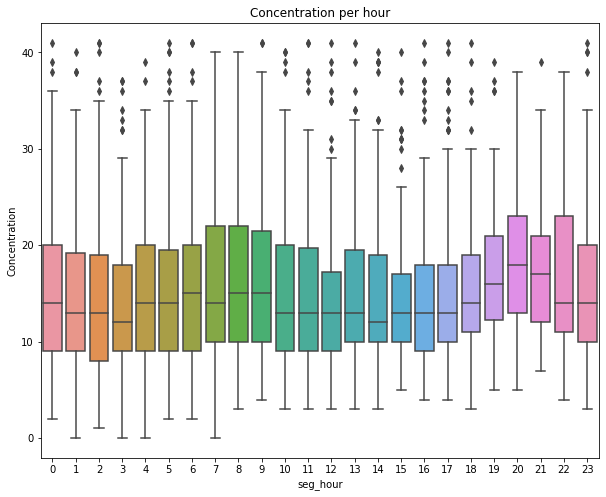

In [23]:
#Concentration per hour boxplot after removing outliesrs
fig, ax= plt.subplots(figsize= (10,8))
sns.boxplot(data=data,x='seg_hour',y='Concentration')
ax.set_title("Concentration per hour")
plt.show()

In [24]:
# Calculate the relevant statistics
median = data['Concentration'].median()
q1 = data['Concentration'].quantile(0.25)
q3 = data['Concentration'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

print("median",median)
print("q1",q1)
print("q3",q3)
print("iqr",iqr)
print("lower bound",lower_bound)
print("upper bound", upper_bound)


median 14.0
q1 10.0
q3 20.0
iqr 10.0
lower bound -5.0
upper bound 35.0


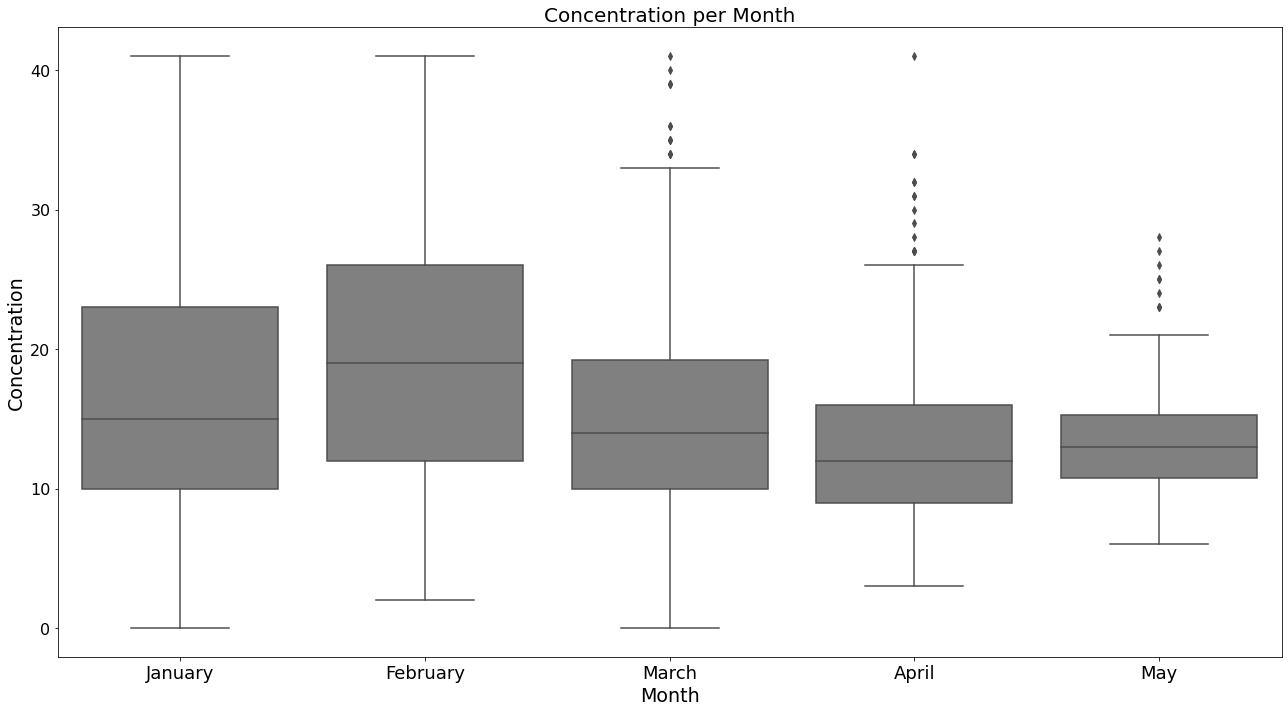

In [22]:
#Creating concentration each month boxplot after removing outliers
fig=plt.figure(figsize=(18,10))
sns.boxplot(data=data,x='month',y='Concentration',color='grey')
plt.title('Concentration per Month',fontsize=20)
plt.xlabel('Month',fontsize=19)
plt.xticks(np.arange(5),labels=['January','February','March','April','May'],fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Concentration',fontsize=19)
plt.tight_layout()
plt.show()

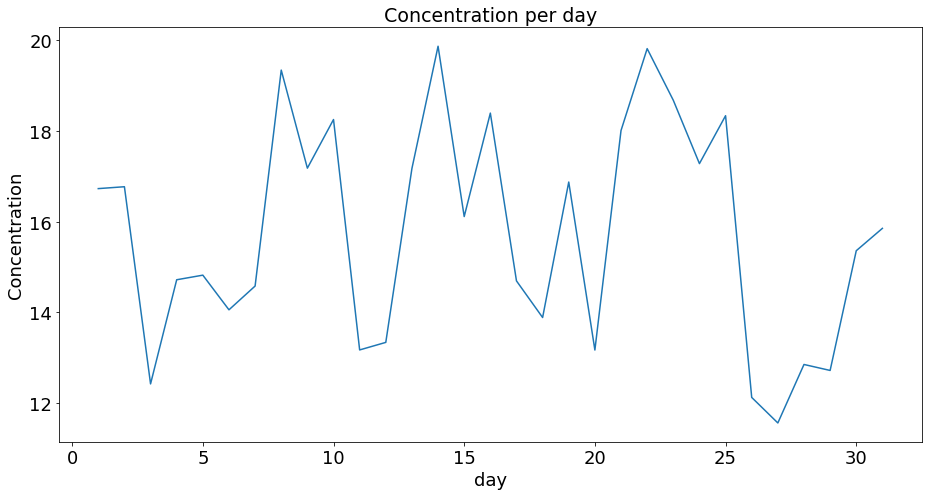

In [23]:
#Creating concentration during each day lineplot after removing outliesrs
fig=plt.figure(figsize=(13,7))
sns.lineplot(data=data,x='day',y='Concentration',ci=None)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Concentration per day',fontsize=19)
plt.xlabel('day',fontsize=18)
plt.ylabel('Concentration',fontsize=18)
plt.tight_layout()
plt.show()

In [24]:
data.head()
data.reset_index(inplace=True)


In [25]:
#previous Hours, windows 2-3 (mean, min, max)
def prev_2hours():
   data['prev_2hours']=[data['Concentration'][i] if i==0 else data['Concentration'][i-1] if i==1 else data['Concentration'][i-2]
                                for i in range(len(data))]
prev_2hours()

def prev_two_hours_mean(): #mean of previous two hours (window = 2)
      data['prev_two_hours_mean']=data['index'].apply(lambda x: data['Concentration'].loc[x-2:x-1].mean()).round()
    
prev_two_hours_mean()
    
def prev_two_hours_min(): #minimum of  previous two on  hours (window = 2)
    data['prev_two_hours_min']=data['index'].apply(lambda x: data['Concentration'].loc[x-2:x-1].min())
prev_two_hours_min()
    
def prev_two_hours_max(): #maximum of previous two  hours (window = 2)
     data['prev_two_hours_max']=data['index'].apply(lambda x: data['Concentration'].loc[x-2:x-1].max())
        
prev_two_hours_max()
    
def prev_three_hours_mean(): #mean of previous three  hours (window = 3)
     data['prev_three_hours_mean']=data['index'].apply(lambda x: data['Concentration'].loc[x-3:x-1].mean()).round()
        
prev_three_hours_mean()
    
def prev_three_hours_min(): #minimum of previous three  hours (window = 3)
     data['prev_three_hours_min']=data['index'].apply(lambda x: data['Concentration'].loc[x-3:x-1].min())
        
prev_three_hours_min()
    
def prev_three_hours_max(): #maximum of previous three hours (window = 3)
     data['prev_three_hours_max']=data['index'].apply(lambda x: data['Concentration'].loc[x-3:x-1].max())
        
prev_three_hours_max()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [26]:
data[['prev_2hours','Concentration']].head(10) #checking variable prev_2hours

,prev_2hours,Concentration
0,41.0,41.0
1,41.0,39.0
2,41.0,30.0
3,39.0,38.0
4,30.0,33.0
5,38.0,36.0
6,33.0,34.0
7,36.0,26.0
8,34.0,23.0
9,26.0,25.0


In [28]:
data[['prev_two_hours_max','prev_two_hours_min','prev_two_hours_mean','prev_2hours','Concentration']].head(25) #checking

,prev_two_hours_max,prev_two_hours_min,prev_two_hours_mean,prev_2hours,Concentration
0,36.0,33.0,34.0,41.0,41.0
1,36.0,34.0,35.0,41.0,39.0
2,34.0,26.0,30.0,41.0,30.0
3,26.0,23.0,24.0,39.0,38.0
4,41.0,40.0,40.0,30.0,33.0
5,41.0,39.0,40.0,38.0,36.0
6,34.0,32.0,33.0,33.0,34.0
7,37.0,32.0,34.0,36.0,26.0
8,39.0,37.0,38.0,34.0,23.0
9,40.0,39.0,40.0,26.0,25.0


In [27]:
#Train Test split
data=data.set_index("DatetimeEnd")
train=data.loc[data.index<"2023-04-15"]
test=data.loc[data.index>="2023-04-15"]

In [28]:
#hape of data train data and test data
print(data.shape)
print(train.shape)
print(test.shape)

(2816, 18)
(2220, 18)
(596, 18)


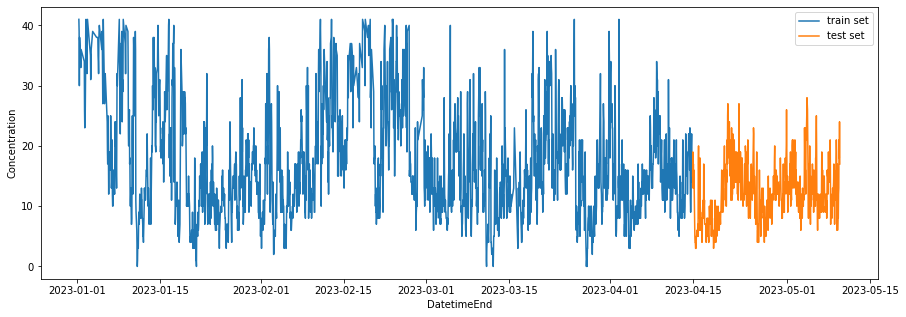

In [29]:
#Train test split Visualization
fig,ax=plt.subplots(figsize=(15,5))
sns.lineplot(data=train,x='DatetimeEnd',y='Concentration')
sns.lineplot(data=test,x='DatetimeEnd',y='Concentration')
ax.legend(['train set','test set'])
plt.show()

In [30]:
data.columns
data['Concentration']=data['Concentration'].round()
data['Concentration'].head()

DatetimeEnd
2023-01-01 06:00:00+00:00    41.0
2023-01-01 07:00:00+00:00    39.0
2023-01-01 08:00:00+00:00    30.0
2023-01-01 09:00:00+00:00    38.0
2023-01-01 14:00:00+00:00    33.0
Name: Concentration, dtype: float64

In [31]:
features=['seg_hour', 'day', 'month', 'weekday',
       'year','weekend', 'day/night',"prev_2hours",
       'prev_two_hours_mean', 'prev_two_hours_min', 'prev_two_hours_max',
       'prev_three_hours_mean', 'prev_three_hours_min',
       'prev_three_hours_max']

target="Concentration"

X_train=train[features]
y_train=train[target]
X_test=test[features]
y_test=test[target]

In [32]:
print(y_train)

DatetimeEnd
2023-01-01 06:00:00+00:00    41.0
2023-01-01 07:00:00+00:00    39.0
2023-01-01 08:00:00+00:00    30.0
2023-01-01 09:00:00+00:00    38.0
2023-01-01 14:00:00+00:00    33.0
                             ... 
2023-04-14 19:00:00+00:00    20.0
2023-04-14 20:00:00+00:00    22.0
2023-04-14 21:00:00+00:00    14.0
2023-04-14 22:00:00+00:00    17.0
2023-04-14 23:00:00+00:00    15.0
Name: Concentration, Length: 2220, dtype: float64


In [33]:
#Baseline model creation (Evaluation metrics: RMSE, MAE)
Baseline_pred=[data['Concentration'][i] if i==0 else data['Concentration'][i-1] if i==1 else data['Concentration'][i-2]
                                for i in range(len(data))]
data_base=data['Concentration']
rmse_base=np.sqrt(mean_squared_error(data_base,Baseline_pred))
mae_base=mean_absolute_error(data_base,Baseline_pred)
mape_base=mean_absolute_percentage_error(data_base,Baseline_pred)
print("RMSE_base:",rmse_base, "MAE_base:",mae_base,"MAPE_base",mape_base)

RMSE_base: 6.008014297207901 MAE_base: 4.311434659090909 MAPE_base 31985792808029.414


In [34]:
#Creating the model
model=xgb.XGBRegressor(n_estimators=1000,learning_rate=0.01)
model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

[0]	validation_0-rmse:18.24724	validation_1-rmse:12.58063
[100]	validation_0-rmse:8.32843	validation_1-rmse:5.47960
[200]	validation_0-rmse:5.35949	validation_1-rmse:3.94752
[300]	validation_0-rmse:4.45057	validation_1-rmse:3.98722
[400]	validation_0-rmse:4.05583	validation_1-rmse:4.19338
[500]	validation_0-rmse:3.84563	validation_1-rmse:4.28448
[600]	validation_0-rmse:3.60968	validation_1-rmse:4.35046
[700]	validation_0-rmse:3.40849	validation_1-rmse:4.40401
[800]	validation_0-rmse:3.22507	validation_1-rmse:4.44329
[900]	validation_0-rmse:3.06978	validation_1-rmse:4.51520
[999]	validation_0-rmse:2.91938	validation_1-rmse:4.55638


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [35]:
x=data[['seg_hour', 'day', 'month', 'weekday',
       'year','weekend', 'day/night','prev_2hours',
       'prev_two_hours_mean', 'prev_two_hours_min', 'prev_two_hours_max',
       'prev_three_hours_mean', 'prev_three_hours_min',
       'prev_three_hours_max']]

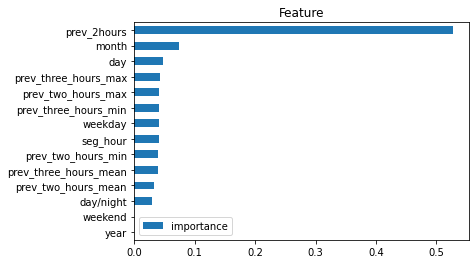

In [36]:
fi=pd.DataFrame(data=model.feature_importances_,index=x.columns,columns=['importance'])
fi.sort_values('importance').plot(kind='barh',title='Feature')
plt.show()

In [37]:
y_pred_train=model.predict(X_train).round()
y_pred_test=model.predict(X_test).round()

In [38]:
mae_train=mean_absolute_error(y_train,y_pred_train)
mae_train

2.1477477477477476

In [39]:
mae_test=mean_absolute_error(y_test,y_pred_test)
mae_test

3.5805369127516777

In [40]:
rmse_train=np.sqrt(mean_squared_error(y_train,y_pred_train))
rmse_train

2.936259801451776

In [41]:
rmse_test=np.sqrt(mean_squared_error(y_test,y_pred_test))
rmse_test

4.573046214270347

In [42]:
data['Concentration'].describe()

count    2816.000000
mean       15.771307
std         8.259958
min         0.000000
25%        10.000000
50%        14.000000
75%        20.000000
max        41.000000
Name: Concentration, dtype: float64

In [43]:
best=model

explainer = shap.TreeExplainer(best)

In [44]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)


Permutation explainer: 597it [02:24,  3.85it/s]                         


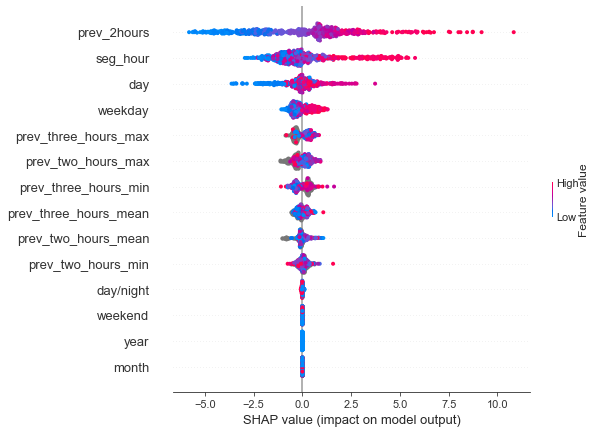

In [45]:
#Shap values Plot
sns.set_style("white")
shap.summary_plot(shap_values)

In [54]:
saved_model_path = '/Users/mariatsiompra/Documents/master/diplwmatiki/Forecasting/saved_model/model.sav'
os.makedirs(os.path.dirname(saved_model_path), exist_ok=True)
pickle.dump(model, open(saved_model_path, 'wb'))

In [56]:
# Load saved model 

# loaded_model = pickle.load(open(saved_model_path, 'rb'))